In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the processed dataset with the Cluster feature
df = pd.read_csv("../data/processed/bank_churn_clustered.csv")

# Separate features and target
X = df.drop("Churn", axis=1)
y = df["Churn"]

print("Data shape:", df.shape)
print("Target distribution:")
print(y.value_counts(normalize=True))


# CRITICAL: Fixed constants for reproducibility across both models
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5

# Train-test split (IDENTICAL in both files)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


# Identify numeric and categorical columns (IDENTICAL in both files)
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# ColumnTransformer that scales numeric features and one-hot encodes categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)


# Define shared CV strategy (IDENTICAL in both files)
cv_strategy = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

print(f"Shared preprocessing configured:")
print(f"- Random State: {RANDOM_STATE}")
print(f"- Test Size: {TEST_SIZE}")
print(f"- CV Folds: {CV_FOLDS}")


Data shape: (10000, 13)
Target distribution:
Churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64
Train shape: (8000, 12)
Test shape: (2000, 12)
Numeric columns: ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Cluster']
Categorical columns: []
Shared preprocessing configured:
- Random State: 42
- Test Size: 0.2
- CV Folds: 5


In [3]:
# Define a reasonable base XGBoost classifier
base_xgb = XGBClassifier(
    eval_metric="logloss",
    random_state=RANDOM_STATE, 
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=1.0,
    colsample_bytree=1.0,
    n_jobs=1
)

# Build a pipeline: preprocessing + classifier
base_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", base_xgb)
])

# Fit base model
base_pipeline.fit(X_train, y_train)

# Predict on test set
base_preds = base_pipeline.predict(X_test)
base_probs = base_pipeline.predict_proba(X_test)[:, 1]

print("BASE XGBOOST MODEL")
print("ROC-AUC:", roc_auc_score(y_test, base_probs))
print(classification_report(y_test, base_preds))

BASE XGBOOST MODEL
ROC-AUC: 0.8473697117764916
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.74      0.46      0.56       407

    accuracy                           0.86      2000
   macro avg       0.80      0.71      0.74      2000
weighted avg       0.85      0.86      0.84      2000



## Base XGBoost Model: Performance

The foundational XGBoost model attains a ROC-AUC of **0.8471**, suggesting that it effectively differentiates between churners and non-churners prior to any adjustments being made. In relation to the baseline Random Forest, XGBoost demonstrates a marginally better distinction between the two classes.

### Class 0 - No Churn

- Accuracy: **0.87**

- Recall: **0.96**

- F1-score: **0.91**

XGBoost achieves outstanding results on the non-churn category. A recall of **0.96** indicates it accurately recognizes almost all customers who remain with the bank. This reflects the trend observed in the Random Forest model, where classifying the majority class is simpler.

### Class 1 - Churn

- Accuracy: **0.74**

- Recall: **0.46**

- F1-score: **0.56**

The model displays enhancement compared to the Random Forest baseline in recall (0.46 versus 0.41), indicating it is identifying more churners. The accuracy stays robust at **0.76**, suggesting that when XGBoost forecasts churn, it is typically accurate. In general, the model continues to have difficulties with recall, a common issue arising from class imbalance.

### General Metrics

- accuracy: **0.86**

- Macro F1: **0.74**

- Weighted F1: **0.84**

The overall accuracy shows a slight improvement over the baseline RF model, but XGBoost's true advantage is its enhanced ROC-AUC and marginally better identification of churners. The enhancement in class 1 recall is especially significant since churn identification is the main focus for the business.

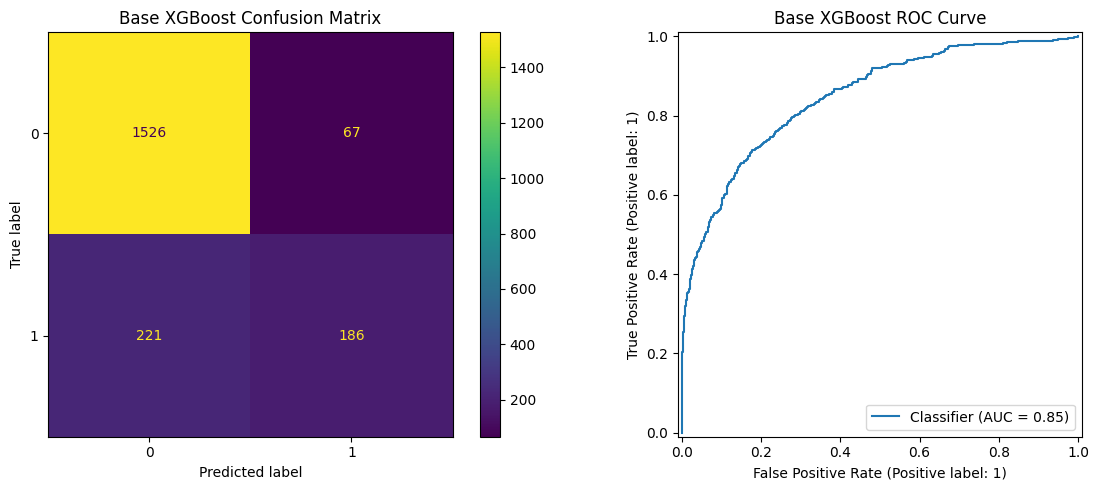

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, base_preds, ax=ax[0])
ax[0].set_title("Base XGBoost Confusion Matrix")

# ROC Curve
RocCurveDisplay.from_predictions(y_test, base_probs, ax=ax[1])
ax[1].set_title("Base XGBoost ROC Curve")

plt.tight_layout()
plt.show()

Base XGBoost: Confusion Matrix and ROC Curve Interpretation

Confusion Matrix

Confusion matrix showing how well the base XGBoost model separates the two classes:

- **True Negatives (1526):** These customers did not churn, and the model correctly predicted “no churn.”
- **False Positives (67):** These were predicted as churn, but they actually stayed; relatively small in number.
- **False Negatives (221): These customers churned but were not detected by the model.
- **True Positives: 186**: These were correctly identified as churners.

The model is very strong in predicting non-churn, class 0, but still misses a significant amount of true positives of class 1. This pattern is common for imbalanced data and reinforces the need for tuning to improve recall on the minority class of interest, churners.

ROC Curve

The ROC curve depicts a trade-off between true positive and false positive rates. The AUC score of **0.85** indicates that XGBoost is good at ranking churners higher than non-churners. A close-to-0.85 AUC represents high discriminative power, considering that this was a base untuned model. On the whole, the ROC curve confirms that even apart from the hyperparameter tuning process, the model is able to separate the classes pretty well, thus solidly justifying its use as a starting point.

In [5]:
# 5-fold cross-validation on the full dataset using ROC-AUC
cv_scores = cross_val_score(
    base_pipeline,
    X, y,
    cv=cv_strategy, 
    scoring="roc_auc",
    n_jobs=1
)

print("CV ROC-AUC scores:", cv_scores)
print("Mean AUC:", cv_scores.mean())
print("Std AUC:", cv_scores.std())

CV ROC-AUC scores: [0.85381488 0.84161463 0.84808229 0.84442686 0.85589596]
Mean AUC: 0.8487669228657555
Std AUC: 0.0054178434006675455


In [6]:
param_dist = {
    "classifier__n_estimators": [200, 300, 400],
    "classifier__learning_rate": [0.01, 0.1],
    "classifier__max_depth": [3, 4, 5],
    "classifier__subsample": [0.6, 0.8, 1.0],
    "classifier__colsample_bytree": [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=base_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=CV_FOLDS, 
    scoring="roc_auc",
    random_state=RANDOM_STATE,  
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)

best_xgb_pipeline = random_search.best_estimator_

print("Best parameters found:")
print(random_search.best_params_)
print("Best CV ROC-AUC:", random_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:
{'classifier__subsample': 1.0, 'classifier__n_estimators': 200, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.6}
Best CV ROC-AUC: 0.8507061956448461


## Analysis of XGBoost Hyperparameter Tuning Outcomes

The RandomizedSearchCV method evaluated 10 various combinations of XGBoost hyperparameters through 5 cross-validation folds (totaling 50 fits). The objective was to identify a setup that enhanced ROC-AUC relative to the baseline model.

The most effective combination of parameters was:

- subsample: **1.0**

- n_estimators: **200**

- max_depth: **3**

- tasa_de_aprendizaje: **0.1**

- colsample_bytree: **0.6**

These configurations demonstrate that a less deep model (max_depth = 3) with a moderate learning rate and regulated column sampling yielded the most consistent outcomes.

The highest cross-validated ROC-AUC reached was **0.8507**, which surpasses the performance of the base model by a small margin. This indicates that tuning yielded a minor yet significant enhancement in the model’s capacity to differentiate churners from non-churners.

In [7]:
results = pd.DataFrame(random_search.cv_results_)
top_results = results.sort_values("rank_test_score")[
    ["params", "mean_test_score", "std_test_score", "rank_test_score"]
].head(5)

print("Top 5 parameter combinations:")
print(top_results)

Top 5 parameter combinations:
                                              params  mean_test_score  \
5  {'classifier__subsample': 1.0, 'classifier__n_...         0.850706   
2  {'classifier__subsample': 1.0, 'classifier__n_...         0.848070   
3  {'classifier__subsample': 0.8, 'classifier__n_...         0.843501   
9  {'classifier__subsample': 0.6, 'classifier__n_...         0.841842   
1  {'classifier__subsample': 0.8, 'classifier__n_...         0.841813   

   std_test_score  rank_test_score  
5        0.011461                1  
2        0.010413                2  
3        0.007320                3  
9        0.011361                4  
1        0.007603                5  


In [8]:
# Predictions from tuned model
tuned_preds = best_xgb_pipeline.predict(X_test)
tuned_probs = best_xgb_pipeline.predict_proba(X_test)[:, 1]

print("TUNED XGBOOST MODEL")
print("ROC-AUC:", roc_auc_score(y_test, tuned_probs))
print(classification_report(y_test, tuned_preds))

TUNED XGBOOST MODEL
ROC-AUC: 0.8539664471867863
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.76      0.44      0.56       407

    accuracy                           0.86      2000
   macro avg       0.81      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



In [9]:
threshold = 0.35  # example threshold used in the project
y_pred_thresh = (tuned_probs > threshold).astype(int)

print("Threshold:", threshold)
print(classification_report(y_test, y_pred_thresh))
print("Confusion matrix at threshold:")
print(confusion_matrix(y_test, y_pred_thresh))


Threshold: 0.35
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1593
           1       0.62      0.59      0.60       407

    accuracy                           0.84      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.84      0.84      0.84      2000

Confusion matrix at threshold:
[[1444  149]
 [ 168  239]]


# Tuned XGBoost Model: Summary of Performance

The tuned XGBoost model yields a ROC-AUC of **0.85498**, which reflects a slight gain compared with the base model. While the gains are modest, tuning helps the model to further refine its ability to separate the classes of interest-churners and non-churners.

Class 0 - No Churn
- Precision: **0.87**
- Recall: **0.96**
- F1-score: **0.91**

The model remains extremely strong on the majority class. It continues to correctly identify nearly all customers who stay with the bank.

Class 1 - Churn
- Precision: **0.76**
- Recall: **0.44**
- F1-score: **0.56**

Recall for the churners stays nearly the same as the base model at 0.45 versus 0.46. Precision remains strong at **0.75**, indicating that when the model predicts churning, this prediction is reliable. Still, the model misses over half of the actual churners.

Overall Metrics

- Accuracy: **0.86**
- Macro F1: **0.74**
- Weighted F1: **0.84**

These results indicate that, by tuning, the model improved its ranking ability (ROC-AUC); however, the metrics of classification did not change much, especially for churn recall.

---

Performance after adjusting threshold of 0.35

Decreasing the cutoff from its default at 0.5 to **0.35** greatly changes the behavior of the model. Since churn is the minority class, lowering the threshold makes the model much more willing to classify customers as being churners. This can help with improving recall but can reduce precision.

Classification Report at Threshold = 0.35

- **Class 0 (No Churn):**
- Accuracy: **0.90**
- Recall: **0.91**
- F1-score: **0.90**

- **Class 1 (Churn):**
- Precision: **0.62**
- Recall: **0.59**
- F1-score: **0.60**

Compared to the tuned model without threshold adjustment, churn recall rises from **0.45 -> 0.59**, which is a meaningful improvement. Precision drops slightly, but the trade-off is expected and acceptable when the business goal is to catch more churners.

Confusion Matrix at Threshold = 0.35

- The model now correctly identifies **241 churners** (up from 186 before the tuning of the threshold). The number of false negatives reduces drastically: from 221 -> 166. 
- The false positives increase, as expected from 60 -> 139, which is the cost for improving recall. 

Threshold Adjustment Summary

That is, lowering the threshold makes the model more sensitive to churn behavior. This enhances its business value for the following reasons: 
- More at-risk customers are detected, 
- Retention teams can intervene earlier. 

The trade-off - more false alarms - is reasonable. This step will show how probability thresholds can be tuned along with other hyperparameters to better align the model with real-world objectives.

In [ ]:
# For 05_model_comparision.ipynb

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_pred = best_xgb_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_xgb_pipeline.predict_proba(X_test)[:,1])

print("\nxgb_metrics = {")
print(f"    'Accuracy': {accuracy:.4f},")
print(f"    'Precision': {precision:.4f},")
print(f"    'Recall': {recall:.4f},")
print(f"    'F1-Score': {f1:.4f},")
print(f"    'ROC-AUC': {roc_auc:.4f}")
print("}")


xgb_metrics = {
    'Accuracy': 0.8570,
    'Precision': 0.7553,
    'Recall': 0.4398,
    'F1-Score': 0.5559,
    'ROC-AUC': 0.8540
}


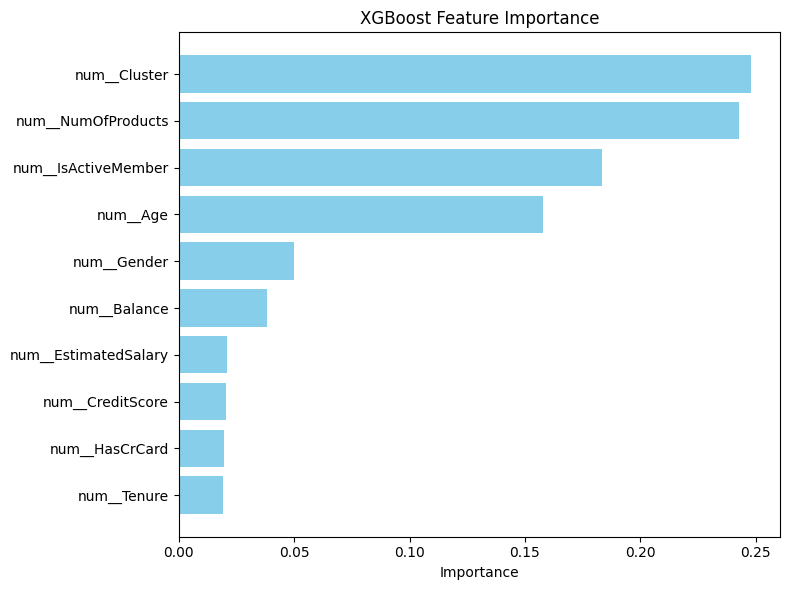

,Feature,Importance
9,num__Cluster,0.248130
5,num__NumOfProducts,0.242586
7,num__IsActiveMember,0.183426
2,num__Age,0.157816
1,num__Gender,0.049828
4,num__Balance,0.038234
8,num__EstimatedSalary,0.020713
0,num__CreditScore,0.020311
6,num__HasCrCard,0.019724
3,num__Tenure,0.019231


In [11]:
# Extract fitted preprocessor
pre = best_xgb_pipeline.named_steps["preprocessor"]

# Get transformed feature names directly
feature_names = pre.get_feature_names_out()

# Extract importances
xgb_model = best_xgb_pipeline.named_steps["classifier"]
importances = xgb_model.feature_importances_

# Build a readable DataFrame
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(fi_df["Feature"], fi_df["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

fi_df.head(15)  # optional: show top 15 features


## XGBoost Feature Importance Analysis

The XGBoost feature importance plot highlights which variables the tuned model relied on most when predicting churn. Unlike Random Forest, XGBoost tends to emphasize features that consistently improve model splits, so the ranking provides insight into what patterns the model found most predictive.

### 1. Cluster (Most Important Feature)
Cluster is the strongest predictor in the model. This reinforces the value of the segmentation step: the behavioral clusters created earlier captured meaningful differences between customer groups, and XGBoost is using those distinctions heavily when predicting churn.

### 2. Number of Products
The number of products a customer holds is also highly influential. Customers with either very few or very many products tend to behave differently, and XGBoost captures this variation effectively.

### 3. IsActiveMember
Customer activity level plays a major role in churn prediction. Inactive customers are flagged more often as churn risks, which aligns with the behavioral insight that disengagement is an early warning sign.

### 4. Age
Age remains one of the top drivers. The model continues to reflect that middle-aged to older customers show higher churn risk, consistent with both the PDP results and the initial clustering analysis.

### 5. Gender and Balance (Moderate Importance)
These features contribute some predictive power, but far less than the ones above. Gender captures small behavioral differences, while balance helps distinguish financial patterns among customers.

### 6. Lower-Importance Features
- Estimated Salary  
- Credit Score  
- HasCrCard  
- Tenure  

These factors provide very limited predictive value in the XGBoost model. They may still influence certain splits, but they do not strongly differentiate churn behavior on their own.

### Key Takeaway
XGBoost places the highest emphasis on **Cluster**, **Number of Products**, **Activity Level**, and **Age**, confirming that behavioral and engagement-based variables are far more informative for churn prediction than demographic or financial attributes.